In [39]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import hello_world, load_dataframes_fannie
hello_world()

Hello World!


# Regime Change Detection




>Regime switching is another way to describe structural changes in a data series. For example, an inflation timeseries may change states from ARMA to linear as the economy moves from a period of cyclical growth to prolonged recession. A stock price may, say, be determined by and correlated to the main equity index when it has a large market capitalisation and then by a sub-index when it's relative size shrinks - consider Apple. Regime switching enables a very powerful dynamic regression analysis of time series by incorporating both of these periods. https://quant.stackexchange.com/questions/30139/what-is-a-regime-switch



>This issue looks at a number of studies of regime-switching in financial markets; a hardy perennial of a research topic, much loved by academics and central bankers, but rather underused by practitioners. The reasons for this unpopularity are many. These reasons are not based on ignorance but on very real difficulties in implementation. Furthermore, the structure of these models sits uncomfortably with the assumptions made by conventional optimisers. Converting these regime structures into global stock selection models with universes of, say, 5000 stocks seems not to be currently feasible.  https://link.springer.com/article/10.1057/jam.2011.32




### Generate Data

In [40]:
import numpy as np
import random
from random import normalvariate
import matplotlib.pyplot as plt

import pandas_datareader.data as web
import pandas as pd
import datetime
import numpy as np
import math
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

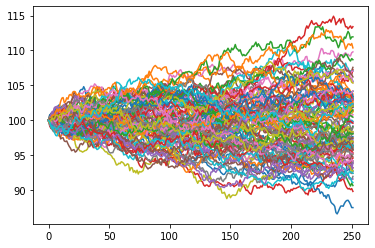

In [41]:

def generate_walk(_predicted_days: int=252,
                  _avg_daily_ret: float=0.011109907589923229/4,
                  _variance: float=0.00012343004665663377,
                  _last_price: float=100):
    count = 0
    avg_daily_ret = _avg_daily_ret
    variance = _variance
    predicted_days = _predicted_days

    daily_vol = np.sqrt(variance)
    daily_drift = avg_daily_ret - (variance/2)
    drift = daily_drift - 0.5 * daily_vol ** 2

    #Append Start Value    
    prices = []

    shock = drift + daily_vol * np.random.normal()
    last_price = _last_price
    prices.append(last_price)

    for i in range(predicted_days):
        if count == 251:
            break
        shock = drift + daily_vol * np.random.normal()
        price = prices[count] * math.exp(shock)
        prices.append(price)


        count += 1
    return prices

Prices = []
for _ in range(100):
    Prices.append(generate_walk(252, 0, 0.00001))
    plt.plot(Prices[-1])

In [42]:
P = np.array(Prices[0])
for idx, p in enumerate(Prices):
    if idx == 0:
        continue
    P = np.vstack([P, p])
    
print(P.shape)

(100, 252)


In [43]:
seq_len = 20
vol_len = 10
sequences = []
volitilies = []

for prices in P:
    for idx, p in enumerate(prices):
        if idx < vol_len:
            continue
        if idx >= len(prices)-seq_len - 2:
            continue
        seq = prices[idx: idx+seq_len]
        deltas = []
        vols = []
        for i, s in enumerate(seq):
            if i == 0:
                l = s
                continue
            deltas.append((s-l)/l)
            jdx = idx + i
            vols.append(np.std(prices[jdx-vol_len:jdx]))
            l=s
        sequences.append(deltas)
        volitilies.append(vols)
        
sequences = np.array(sequences)
volatilities = np.array(volitilies)

In [44]:
print(sequences.shape)

(22000, 19)


In [45]:
print(volatilities.shape)

(22000, 19)


In [46]:
features = []
for S, V in zip(sequences, volatilities):
    feats = []
    for s, v in zip(S,V):
        feats.append([s, v])
    features.append(feats)
    
features = np.array(features)
print(features.shape)

(22000, 19, 2)


In [47]:
print(features[0])

[[ 2.15630578e-04  3.11489529e-01]
 [ 7.99142615e-04  2.83573902e-01]
 [-4.72566701e-03  2.74161503e-01]
 [ 2.39389142e-03  2.84617898e-01]
 [-3.15413289e-03  2.00039966e-01]
 [ 1.23065704e-03  2.34530782e-01]
 [-7.83968259e-04  2.40798143e-01]
 [ 1.02498913e-03  1.91888867e-01]
 [ 2.54749380e-03  1.93490380e-01]
 [ 1.00060411e-03  1.91567660e-01]
 [-3.09590439e-03  1.97370422e-01]
 [-3.59763246e-03  1.85425091e-01]
 [ 7.53435677e-03  1.88513835e-01]
 [ 1.07783931e-03  2.23093874e-01]
 [ 4.22539381e-04  2.64619761e-01]
 [ 2.16411254e-03  2.85523078e-01]
 [-1.85819126e-03  3.31296224e-01]
 [ 2.31065599e-04  3.22644095e-01]
 [-2.97930559e-03  3.13703072e-01]]


# Constructing LSTM Autoencoder Model

## What is an Autoencoder?

https://en.wikipedia.org/wiki/Autoencoder

>An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. Several variants exist to the basic model, with the aim of forcing the learned representations of the input to assume useful properties.[2] Examples are the regularized autoencoders (Sparse, Denoising and Contractive autoencoders), proven effective in learning representations for subsequent classification tasks,[3] and Variational autoencoders, with their recent applications as generative models.[4] Autoencoders are effectively used for solving many applied problems, from face recognition [5] to acquiring the semantic meaning for the words.[6][7]

### Anomaly Detection
>Another field of application for autoencoders is anomaly detection.[33][34][35][36] By learning to replicate the most salient features in the training data under some of the constraints described previously, the model is encourage to learn how to precisely reproduce the most frequent characteristics of the observations. When facing anomalies, the model should worsen its reconstruction performance. In most cases, only data with normal instances are used to train the autoencoder; in others, the frequency of anomalies is so small compared to the whole population of observations, that its contribution to the representation learnt by the model could be ignored. After training, the autoencoder will reconstruct normal data very well, while failing to do so with anomaly data which the autoencoder has not encountered.[34] Reconstruction error of a data point, which is the error between the original data point and its low dimensional reconstruction, is used as an anomaly score to detect anomalies.[34]

Papers:
- https://dl.acm.org/citation.cfm?id=3098052
>_Anomaly Detection with Robust Deep Autoencoders_ .Deep autoencoders, and other deep neural networks, have demonstrated their effectiveness in discovering non-linear features across many problem domains. However, in many real-world problems, large outliers and pervasive noise are commonplace, and one may not have access to clean training data as required by standard deep denoising autoencoders. Herein, we demonstrate novel extensions to deep autoencoders which not only maintain a deep autoencoders' ability to discover high quality, non-linear features but can also eliminate outliers and noise without access to any clean training data. Our model is inspired by Robust Principal Component Analysis, and we split the input data X into two parts, $X = L_{D} + S$, where $L_{D}$ can be effectively reconstructed by a deep autoencoder and $S$ contains the outliers and noise in the original data X. Since such splitting increases the robustness of standard deep autoencoders, we name our model a "Robust Deep Autoencoder (RDA)". Further, we present generalizations of our results to grouped sparsity norms which allow one to distinguish random anomalies from other types of structured corruptions, such as a collection of features being corrupted across many instances or a collection of instances having more corruptions than their fellows. Such "Group Robust Deep Autoencoders (GRDA)" give rise to novel anomaly detection approaches whose superior performance we demonstrate on a selection of benchmark problems.

![](imgs/Autoencoder_structure.png)

In [48]:
import tensorflow as tf
from os import environ
environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

In [49]:
dataset = tf.data.Dataset.from_tensor_slices(features)

SHUFFLE_BUFFER_SIZE = 256
BATCH_SIZE = 64

dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

dataset

<BatchDataset shapes: (None, 19, 2), types: tf.float64>

### Construct Model Using TensorFlow Keras Functional API

We will construct the model two ways using the TensorFlow Keras Functional API.
1. A single network where we give an input and we get an output, and
2. A two part network where we can separate the output of the encoder from the output of the entire network.


#### Repeat Vector
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector#example

```
model = Sequential()
model.add(Dense(32, input_dim=32))
# now: model.output_shape == (None, 32)
# note: `None` is the batch dimension

model.add(RepeatVector(3))
# now: model.output_shape == (None, 3, 32)

```

In [50]:

# First Entire Network
def construct_model(data):
    print(data.shape)
    inputs = tf.keras.Input(shape=(data.shape[1], data.shape[2]))
    encoder_0 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
    encoder_1 = tf.keras.layers.LSTM(64, return_sequences=False)(encoder_0)
    RV = tf.keras.layers.RepeatVector(data.shape[1])(encoder_1)
    decoder_0 = tf.keras.layers.LSTM(64, return_sequences=True)(RV)
    decoder_1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_0)
    output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            data.shape[2]
        )
    )(decoder_1)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

model = construct_model(features)
model.summary()
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

(22000, 19, 2)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 19, 2)]           0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 19, 128)           67072     
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 19, 64)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 19, 64)            33024     
_________________________________________________________________
lstm_37 (LSTM)               (None, 19, 128)           98816     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 19, 2) 

### Encoder / Decoder
One benefit of the _Encoder Decoder_ architecture is that we can train the full model, and then use the encoder portion (which is trained while training the full model) for clustering, classification, or as an introductory component for another network.

In [51]:
def construct_encoder_decoder(data):
    inputs = tf.keras.Input(shape=(data.shape[1], data.shape[2]))
    encoder_0 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
    encoder_1 = tf.keras.layers.LSTM(64, return_sequences=False)(encoder_0)
    Encoder = tf.keras.Model(
        inputs=inputs,
        outputs=encoder_1,
        name="encoder"
    )
    encoder_center = tf.keras.layers.RepeatVector(data.shape[1])(encoder_1)
    decoder_0 = tf.keras.layers.LSTM(64, return_sequences=True)(encoder_center)
    decoder_1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_0)
    decoded_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(data.shape[2]))(decoder_1)
    model = tf.keras.Model(
        inputs=inputs, 
        outputs=decoded_last,
        name='entire_model'
    )
    return model, Encoder


entire, encoder = construct_encoder_decoder(features)
print("""

Entire Model Summary

""")
entire.summary()
print("""

Encoder Model Summary

""")
encoder.summary()
entire.compile(
    optimizer='adam',
    loss='mae',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)



Entire Model Summary


Model: "entire_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 19, 2)]           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 19, 128)           67072     
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 19, 64)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 19, 64)            33024     
_________________________________________________________________
lstm_41 (LSTM)               (None, 19, 128)           98816     
_________________________________________________________________
time_distributed_8 (TimeDist 

In [52]:
model.fit(
    features, features,
    epochs=10, batch_size=32
)

Train on 22000 samples
Epoch 1/10
22000/22000 [==============================] - 23s 1ms/sample - loss: 0.0340 - root_mean_squared_error: 0.0672
Epoch 2/10
22000/22000 [==============================] - 19s 869us/sample - loss: 0.0175 - root_mean_squared_error: 0.0303
Epoch 3/10
22000/22000 [==============================] - 20s 893us/sample - loss: 0.0145 - root_mean_squared_error: 0.0244
Epoch 4/10
22000/22000 [==============================] - 20s 901us/sample - loss: 0.0130 - root_mean_squared_error: 0.0217
Epoch 5/10
22000/22000 [==============================] - 20s 920us/sample - loss: 0.0121 - root_mean_squared_error: 0.0199
Epoch 6/10
22000/22000 [==============================] - 20s 917us/sample - loss: 0.0117 - root_mean_squared_error: 0.0193
Epoch 7/10
22000/22000 [==============================] - 20s 922us/sample - loss: 0.0112 - root_mean_squared_error: 0.0183
Epoch 8/10
22000/22000 [==============================] - 21s 934us/sample - loss: 0.0105 - root_mean_squared_e

(100, 252)
(22000, 19, 2)


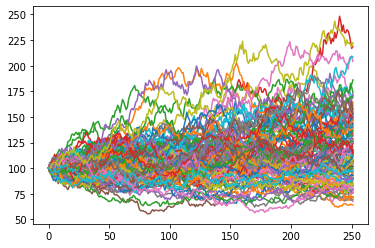

In [53]:

Prices = []
for _ in range(100):
    Prices.append(generate_walk(252, 0.001, 0.0005))
    plt.plot(Prices[-1])

P = np.array(Prices[0])
for idx, p in enumerate(Prices):
    if idx == 0:
        continue
    P = np.vstack([P, p])
    
print(P.shape)
    
seq_len = 20
vol_len = 10
sequences = []
volitilies = []

for prices in P:
    for idx, p in enumerate(prices):
        if idx < vol_len:
            continue
        if idx >= len(prices)-seq_len - 2:
            continue
        seq = prices[idx: idx+seq_len]
        deltas = []
        vols = []
        for i, s in enumerate(seq):
            if i == 0:
                l = s
                continue
            deltas.append((s-l)/l)
            jdx = idx + i
            vols.append(np.std(prices[jdx-vol_len:jdx]))
            l=s
        sequences.append(deltas)
        volitilies.append(vols)
        
sequences = np.array(sequences)
volatilities = np.array(volitilies)

test_features = []
for S, V in zip(sequences, volatilities):
    feats = []
    for s, v in zip(S,V):
        feats.append([s, v])
    test_features.append(feats)
    
test_features = np.array(test_features)
print(test_features.shape)

In [54]:
xTest = test_features[0:10]

yhat = model.predict([xTest])

In [55]:
diff = np.abs(yhat-xTest)

In [56]:
np.mean(np.sum(diff, axis=2))

2.2792272790091728

In [57]:
xOrig = features[0:9]
yOrig = model.predict([xOrig])
origDiff = np.abs(yOrig-xOrig)
print(np.mean(np.sum(origDiff, axis=2)))

0.017120121483130774
